In [1]:
# !unzip './IMU dataset/Curve_fast-2024-10-16_21-43-07.zip' -d './IMU dataset/Curve_fast'
# !unzip './IMU dataset/Curve_slow-2024-10-16_21-38-29.zip' -d './IMU dataset/Curve_slow'
# !unzip './IMU dataset/Straight_fast-2024-10-16_21-34-59.zip' -d './IMU dataset/Straight_fast'
# !unzip './IMU dataset/Straight_slow-2024-10-16_21-29-36.zip' -d './IMU dataset/Straight_slow'
# !unzip './IMU dataset/27_meters_mixed.zip' -d './IMU dataset/27_meters_mixed'

## Data Loading and Preprocessing

In [2]:
import pandas as pd
import numpy as np

# CSV files
accelerometer_files = [
    './IMU dataset/Curve_fast/Accelerometer.csv',
    './IMU dataset/Curve_slow/Accelerometer.csv',
    './IMU dataset/Straight_fast/Accelerometer.csv',
    './IMU dataset/Straight_slow/Accelerometer.csv'
]
gyroscope_files = [
    './IMU dataset/Curve_fast/Gyroscope.csv',
    './IMU dataset/Curve_slow/Gyroscope.csv',
    './IMU dataset/Straight_fast/Gyroscope.csv',
    './IMU dataset/Straight_slow/Gyroscope.csv',
]


def load_sensor_data(file_list):
    data_list = []
    for file in file_list:
        df = pd.read_csv(file)
        data_list.append(df)
    return data_list

accelerometer_data = load_sensor_data(accelerometer_files)
gyroscope_data = load_sensor_data(gyroscope_files)
accelerometer_data_test = load_sensor_data(['./IMU dataset/27_meters_mixed/Accelerometer.csv'])
gyroscope_data_test = load_sensor_data(['./IMU dataset/27_meters_mixed/Gyroscope.csv'])

In [3]:
from sklearn.preprocessing import StandardScaler

def preprocess_sensor_data(df, sensor_type):
    # Normalize the sensor data
    scaler = StandardScaler()
    df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

    # Apply a moving average filter to reduce noise
    df[['x', 'y', 'z']] = df[['x', 'y', 'z']].rolling(window=5).mean()
    df = df.dropna().reset_index(drop=True)

    # Resample the data to a uniform sampling rate (e.g., 25 Hz)
    df['time'] = pd.to_datetime(df['time'], unit='ns')
    df = df.set_index('time').resample('40ms').mean().interpolate()
    df = df.reset_index()

    # Add sensor type prefix to columns to differentiate between accelerometer and gyroscope data
    df = df.rename(columns={'x': f'{sensor_type}_x', 'y': f'{sensor_type}_y', 'z': f'{sensor_type}_z'})

    # Compute Magnitude
    df[f'{sensor_type}_magnitude'] = df[f'{sensor_type}_x']**2 + df[f'{sensor_type}_y']**2 + df[f'{sensor_type}_z']**2

    return df

# Preprocess accelerometer and gyroscope data
processed_accelerometer_data = [preprocess_sensor_data(df, 'accel') for df in accelerometer_data]
processed_gyroscope_data = [preprocess_sensor_data(df, 'gyro') for df in gyroscope_data]
processed_accelerometer_data_test = [preprocess_sensor_data(df, 'accel') for df in accelerometer_data_test]
processed_gyroscope_data_test = [preprocess_sensor_data(df, 'gyro') for df in gyroscope_data_test]

## Segmenting Motion Data



### 5 meters

In [4]:
# Create activity density using standard deviation
for accel_df in processed_accelerometer_data:
    window_size = len(accel_df) // 100
    accel_df['activity_density'] = accel_df['accel_z'].rolling(window=window_size).std()

for accel_df in processed_accelerometer_data_test:
    window_size = len(accel_df) // 100
    accel_df['activity_density'] = accel_df['accel_z'].rolling(window=window_size).std()

In [5]:
def segment_motions(df, threshold=0.2, min_width=75):

    # Initialize variables for segmenting
    time_segments = []
    in_segment = False
    start_idx = None

    # Loop through each index and identify segments
    for i in range(len(df)):
        if df['activity_density'].iloc[i] > threshold:
            if not in_segment:  # Start of a new segment
                in_segment = True
                start_idx = i
        else:
            if in_segment:  # End of the current segment
                in_segment = False
                end_idx = i
                if end_idx - start_idx >= min_width:  # Check segment length
                    time_segments.append(df.iloc[start_idx:end_idx].copy())

    # Check if there was an ongoing segment at the end of the data
    if in_segment and len(df) - start_idx >= min_width:
        time_segments.append(df.iloc[start_idx:].copy())

    return time_segments


# Segment the processed data into individual motions
all_motion_segments = []
for accel_df, gyro_df in zip(processed_accelerometer_data, processed_gyroscope_data):
    # Merge accelerometer and gyroscope data on time
    merged_df = pd.merge_asof(accel_df, gyro_df, on='time', direction='nearest')
    motion_segments = segment_motions(merged_df)
    all_motion_segments.extend([(m, 5.0) for m in motion_segments])

all_motion_segments_test = []
for accel_df, gyro_df in zip(processed_accelerometer_data_test, processed_gyroscope_data_test):
    # Merge accelerometer and gyroscope data on time
    merged_df = pd.merge_asof(accel_df, gyro_df, on='time', direction='nearest')
    all_motion_segments_test.append(merged_df)

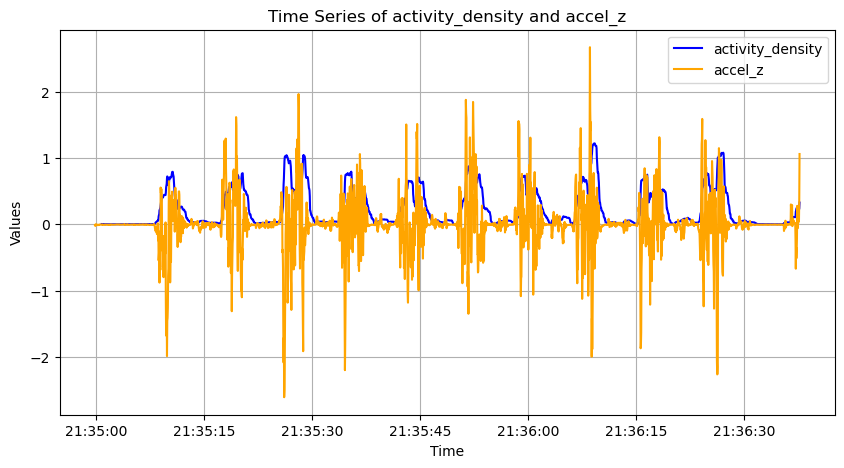

In [6]:
import matplotlib.pyplot as plt

def plot_with_segments(df, col1='activity_density', col2='accel_z'):
    # Create graph
    plt.figure(figsize=(10, 5))
    plt.plot(df['time'], df[col1], label=col1, color='blue')
    plt.plot(df['time'], df[col2], label=col2, color='orange')

    # add title and label
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f'Time Series of {col1} and {col2}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_with_segments(processed_accelerometer_data[2], col1='activity_density', col2='accel_z')


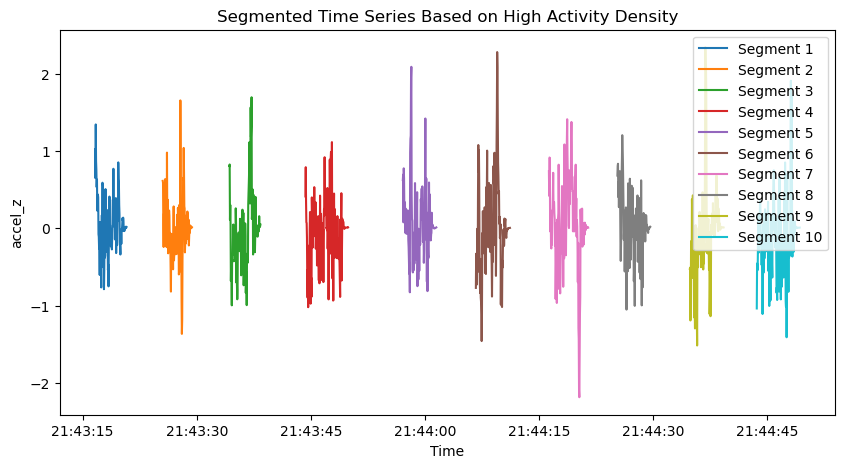

In [7]:
plt.figure(figsize=(10, 5))
for i, (segment, _) in enumerate(all_motion_segments[0:10]):
    plt.plot(segment['time'], segment['accel_z'], label=f'Segment {i+1}')
plt.xlabel('Time')
plt.ylabel('accel_z')
plt.title('Segmented Time Series Based on High Activity Density')
plt.legend()
plt.show()

In [8]:
len(all_motion_segments), len(all_motion_segments_test)

(40, 1)

## Verifying the Target Variable

In [9]:
def verify_segments(segment):
    # Convert 'time' column to seconds
    time_seconds = segment['time'].apply(lambda x: x.timestamp()).values
    time_diffs = time_seconds - time_seconds[0]  # Normalize to start from zero

    accel = segment['accel_z'].std()

    return 1/2 * accel * (time_diffs[-1] ** 2)

# Verify the displacement for each segment
for idx, (segment, _) in enumerate(all_motion_segments):
    displacement = verify_segments(segment)
    print(f"Segment {idx+1}: Estimated Displacement = {displacement:.2f} meters")

Segment 1: Estimated Displacement = 3.23 meters
Segment 2: Estimated Displacement = 3.17 meters
Segment 3: Estimated Displacement = 4.23 meters
Segment 4: Estimated Displacement = 6.69 meters
Segment 5: Estimated Displacement = 4.76 meters
Segment 6: Estimated Displacement = 6.20 meters
Segment 7: Estimated Displacement = 8.02 meters
Segment 8: Estimated Displacement = 4.05 meters
Segment 9: Estimated Displacement = 6.07 meters
Segment 10: Estimated Displacement = 8.19 meters
Segment 11: Estimated Displacement = 6.74 meters
Segment 12: Estimated Displacement = 9.00 meters
Segment 13: Estimated Displacement = 4.14 meters
Segment 14: Estimated Displacement = 4.09 meters
Segment 15: Estimated Displacement = 8.25 meters
Segment 16: Estimated Displacement = 6.27 meters
Segment 17: Estimated Displacement = 6.20 meters
Segment 18: Estimated Displacement = 6.07 meters
Segment 19: Estimated Displacement = 6.02 meters
Segment 20: Estimated Displacement = 7.90 meters
Segment 21: Estimated Displac

## Data Augmentation

### 1-50 meters

In [10]:
# Calculate start time, end time, and duration for each segment
def annotate_segments(all_motion_segments):
    annotated = []
    cumulative_distance = 0.0
    for i, (df, dist) in enumerate(all_motion_segments):
        start_time = df['time'].iloc[0]  # Start time of the segment
        end_time = df['time'].iloc[-1]  # End time of the segment
        duration = (end_time - start_time).total_seconds()  # Duration in seconds
        annotated.append({
            'df': df,
            'distance': dist,  # Distance covered by this segment (e.g., 5.0 meters)
            'start_distance': cumulative_distance,   # Cumulative distance at the start of this segment
            'end_distance': cumulative_distance + dist,  # Cumulative distance at the end of this segment
            'start_time': start_time,
            'end_time': end_time,
            'duration': duration
        })
        cumulative_distance += dist
    return annotated

annotated_segments = annotate_segments(all_motion_segments)

In [11]:
def get_time_slice_from_segment(segment, start_fraction, end_fraction):
    """
    Extract a time slice from a segment based on start and end fractions (values between 0 and 1).
    start_fraction = 0 indicates the start of the segment, and 1 indicates the end of the segment.
    """
    df = segment['df']
    duration = segment['duration']
    start_time = segment['start_time'] + pd.Timedelta(seconds=duration * start_fraction)
    end_time = segment['start_time'] + pd.Timedelta(seconds=duration * end_fraction)
    # Filter data within the specified time range
    sliced_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
    return sliced_df


def get_window_data(annotated_segments, start_meter, length_meter):
    """
    Given a starting meter (start_meter) and a window length (length_meter),
    return the corresponding data window as a DataFrame.
    """
    end_meter = start_meter + length_meter

    # Identify the range of segments that the window spans
    # A segment is selected if start_distance <= start_meter < end_distance
    # for the starting segment, and similarly for the ending segment.
    # Segments in between are fully included if the window spans multiple segments.

    # Find the starting segment
    start_seg_idx = None
    for i, seg in enumerate(annotated_segments):
        if seg['start_distance'] <= start_meter < seg['end_distance']:
            start_seg_idx = i
            break

    # Find the ending segment
    end_seg_idx = None
    for i, seg in enumerate(annotated_segments):
        if seg['start_distance'] < end_meter <= seg['end_distance']:
            end_seg_idx = i
            break

    # If the window is entirely within a single segment (suitable for small windows),
    # start_seg_idx == end_seg_idx. Otherwise, the window spans multiple segments.

    result_dfs = []

    # Handle the starting segment's portion
    start_seg = annotated_segments[start_seg_idx]
    # Calculate the relative distance within the starting segment for start_meter
    start_rel_distance = (start_meter - start_seg['start_distance'])  # Distance relative to the segment start
    start_fraction = start_rel_distance / start_seg['distance']      # Proportion within the segment (0 to 1)

    # Handle the ending segment's portion
    end_seg = annotated_segments[end_seg_idx]
    end_rel_distance = (end_meter - end_seg['start_distance'])
    end_fraction = end_rel_distance / end_seg['distance']

    if start_seg_idx == end_seg_idx:
        # The entire window is within the same segment
        sliced = get_time_slice_from_segment(start_seg, start_fraction, end_fraction)
        result_dfs.append(sliced)
    else:
        # Starting segment (from start_fraction to 1.0)
        start_part = get_time_slice_from_segment(start_seg, start_fraction, 1.0)
        result_dfs.append(start_part)

        # Fully include middle segments (if any)
        for mid_idx in range(start_seg_idx+1, end_seg_idx):
            mid_seg = annotated_segments[mid_idx]
            # Extract the entire segment
            full_mid_seg = get_time_slice_from_segment(mid_seg, 0.0, 1.0)
            result_dfs.append(full_mid_seg)

        # Ending segment (from 0.0 to end_fraction)
        end_part = get_time_slice_from_segment(end_seg, 0.0, end_fraction)
        result_dfs.append(end_part)

    # Combine all parts
    window_df = pd.concat(result_dfs).sort_values(by='time').reset_index(drop=True)
    return window_df


# Generate all windows from 1 meter to 50 meters
extended_all_motion_segments = []
for L in range(1, 51):
    num_windows = 50 - L + 1
    for start_m in range(num_windows):
        wdf = get_window_data(annotated_segments, start_meter=start_m, length_meter=float(L))
        extended_all_motion_segments.append((wdf, float(L)))

In [12]:
len(extended_all_motion_segments)

1275

In [13]:
from collections import Counter, OrderedDict
OrderedDict(sorted(Counter([label for _, label in extended_all_motion_segments]).items(), reverse=True))

OrderedDict([(50.0, 1),
             (49.0, 2),
             (48.0, 3),
             (47.0, 4),
             (46.0, 5),
             (45.0, 6),
             (44.0, 7),
             (43.0, 8),
             (42.0, 9),
             (41.0, 10),
             (40.0, 11),
             (39.0, 12),
             (38.0, 13),
             (37.0, 14),
             (36.0, 15),
             (35.0, 16),
             (34.0, 17),
             (33.0, 18),
             (32.0, 19),
             (31.0, 20),
             (30.0, 21),
             (29.0, 22),
             (28.0, 23),
             (27.0, 24),
             (26.0, 25),
             (25.0, 26),
             (24.0, 27),
             (23.0, 28),
             (22.0, 29),
             (21.0, 30),
             (20.0, 31),
             (19.0, 32),
             (18.0, 33),
             (17.0, 34),
             (16.0, 35),
             (15.0, 36),
             (14.0, 37),
             (13.0, 38),
             (12.0, 39),
             (11.0, 40),
         

### Jittering, Scaling, Time Warping

In [14]:
# Set a global random seed for reproducibility
np.random.seed(42)

def augment_data(all_motion_segments):
    augmented_segments = []
    augmented_targets = []

    # Data Augmentation: Jittering, Scaling, Time Warping
    for segment, target in all_motion_segments:

        # Original segments and their targets (5 meters)
        augmented_segments.append(segment)
        augmented_targets.append(target)

        # Jittering: add small random noise to sensor data
        jittered_segment = segment.copy()
        jitter_values = np.random.normal(0, 0.01, jittered_segment[['accel_x', 'accel_y', 'accel_z', 'accel_magnitude', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_magnitude']].shape)
        jittered_segment[['accel_x', 'accel_y', 'accel_z', 'accel_magnitude', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_magnitude']] += jitter_values
        augmented_segments.append(jittered_segment)
        augmented_targets.append(target)

        # Scaling: multiply sensor data by a scaling factor
        scaling_factor = np.random.uniform(0.9, 1.1)
        scaled_segment = segment.copy()
        scaled_segment[['accel_x', 'accel_y', 'accel_z', 'accel_magnitude', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_magnitude']] *= scaling_factor
        augmented_segments.append(scaled_segment)
        augmented_targets.append(target)

        # Time Warping: simulate stretching/compressing the time axis
        time_warp_factor = np.random.uniform(0.9, 1.1)
        time_warped_segment = segment.copy()
        # Resample the dataframe to simulate time warping
        time_warped_segment = time_warped_segment.set_index('time')
        original_time = time_warped_segment.index.values.astype(np.int64) / 1e9  # Convert nanoseconds to seconds
        new_length = int(len(time_warped_segment) * time_warp_factor)
        new_time = np.linspace(original_time[0], original_time[-1], new_length)
        new_time = pd.to_datetime(new_time, unit='s')  # Convert seconds back to datetime
        time_warped_segment = time_warped_segment.reindex(new_time, method='nearest').interpolate(method='linear')
        # # Resample to a uniform rate
        # time_warped_segment = time_warped_segment.resample('40ms').mean().interpolate()
        time_warped_segment = time_warped_segment.reset_index().rename(columns={'index': 'time'})
        augmented_segments.append(time_warped_segment)
        augmented_targets.append(target)

    return augmented_segments, augmented_targets

# Apply data augmentation to all motion segments
augmented_segments, augmented_targets = augment_data(extended_all_motion_segments)


In [15]:
len(augmented_segments)

5100

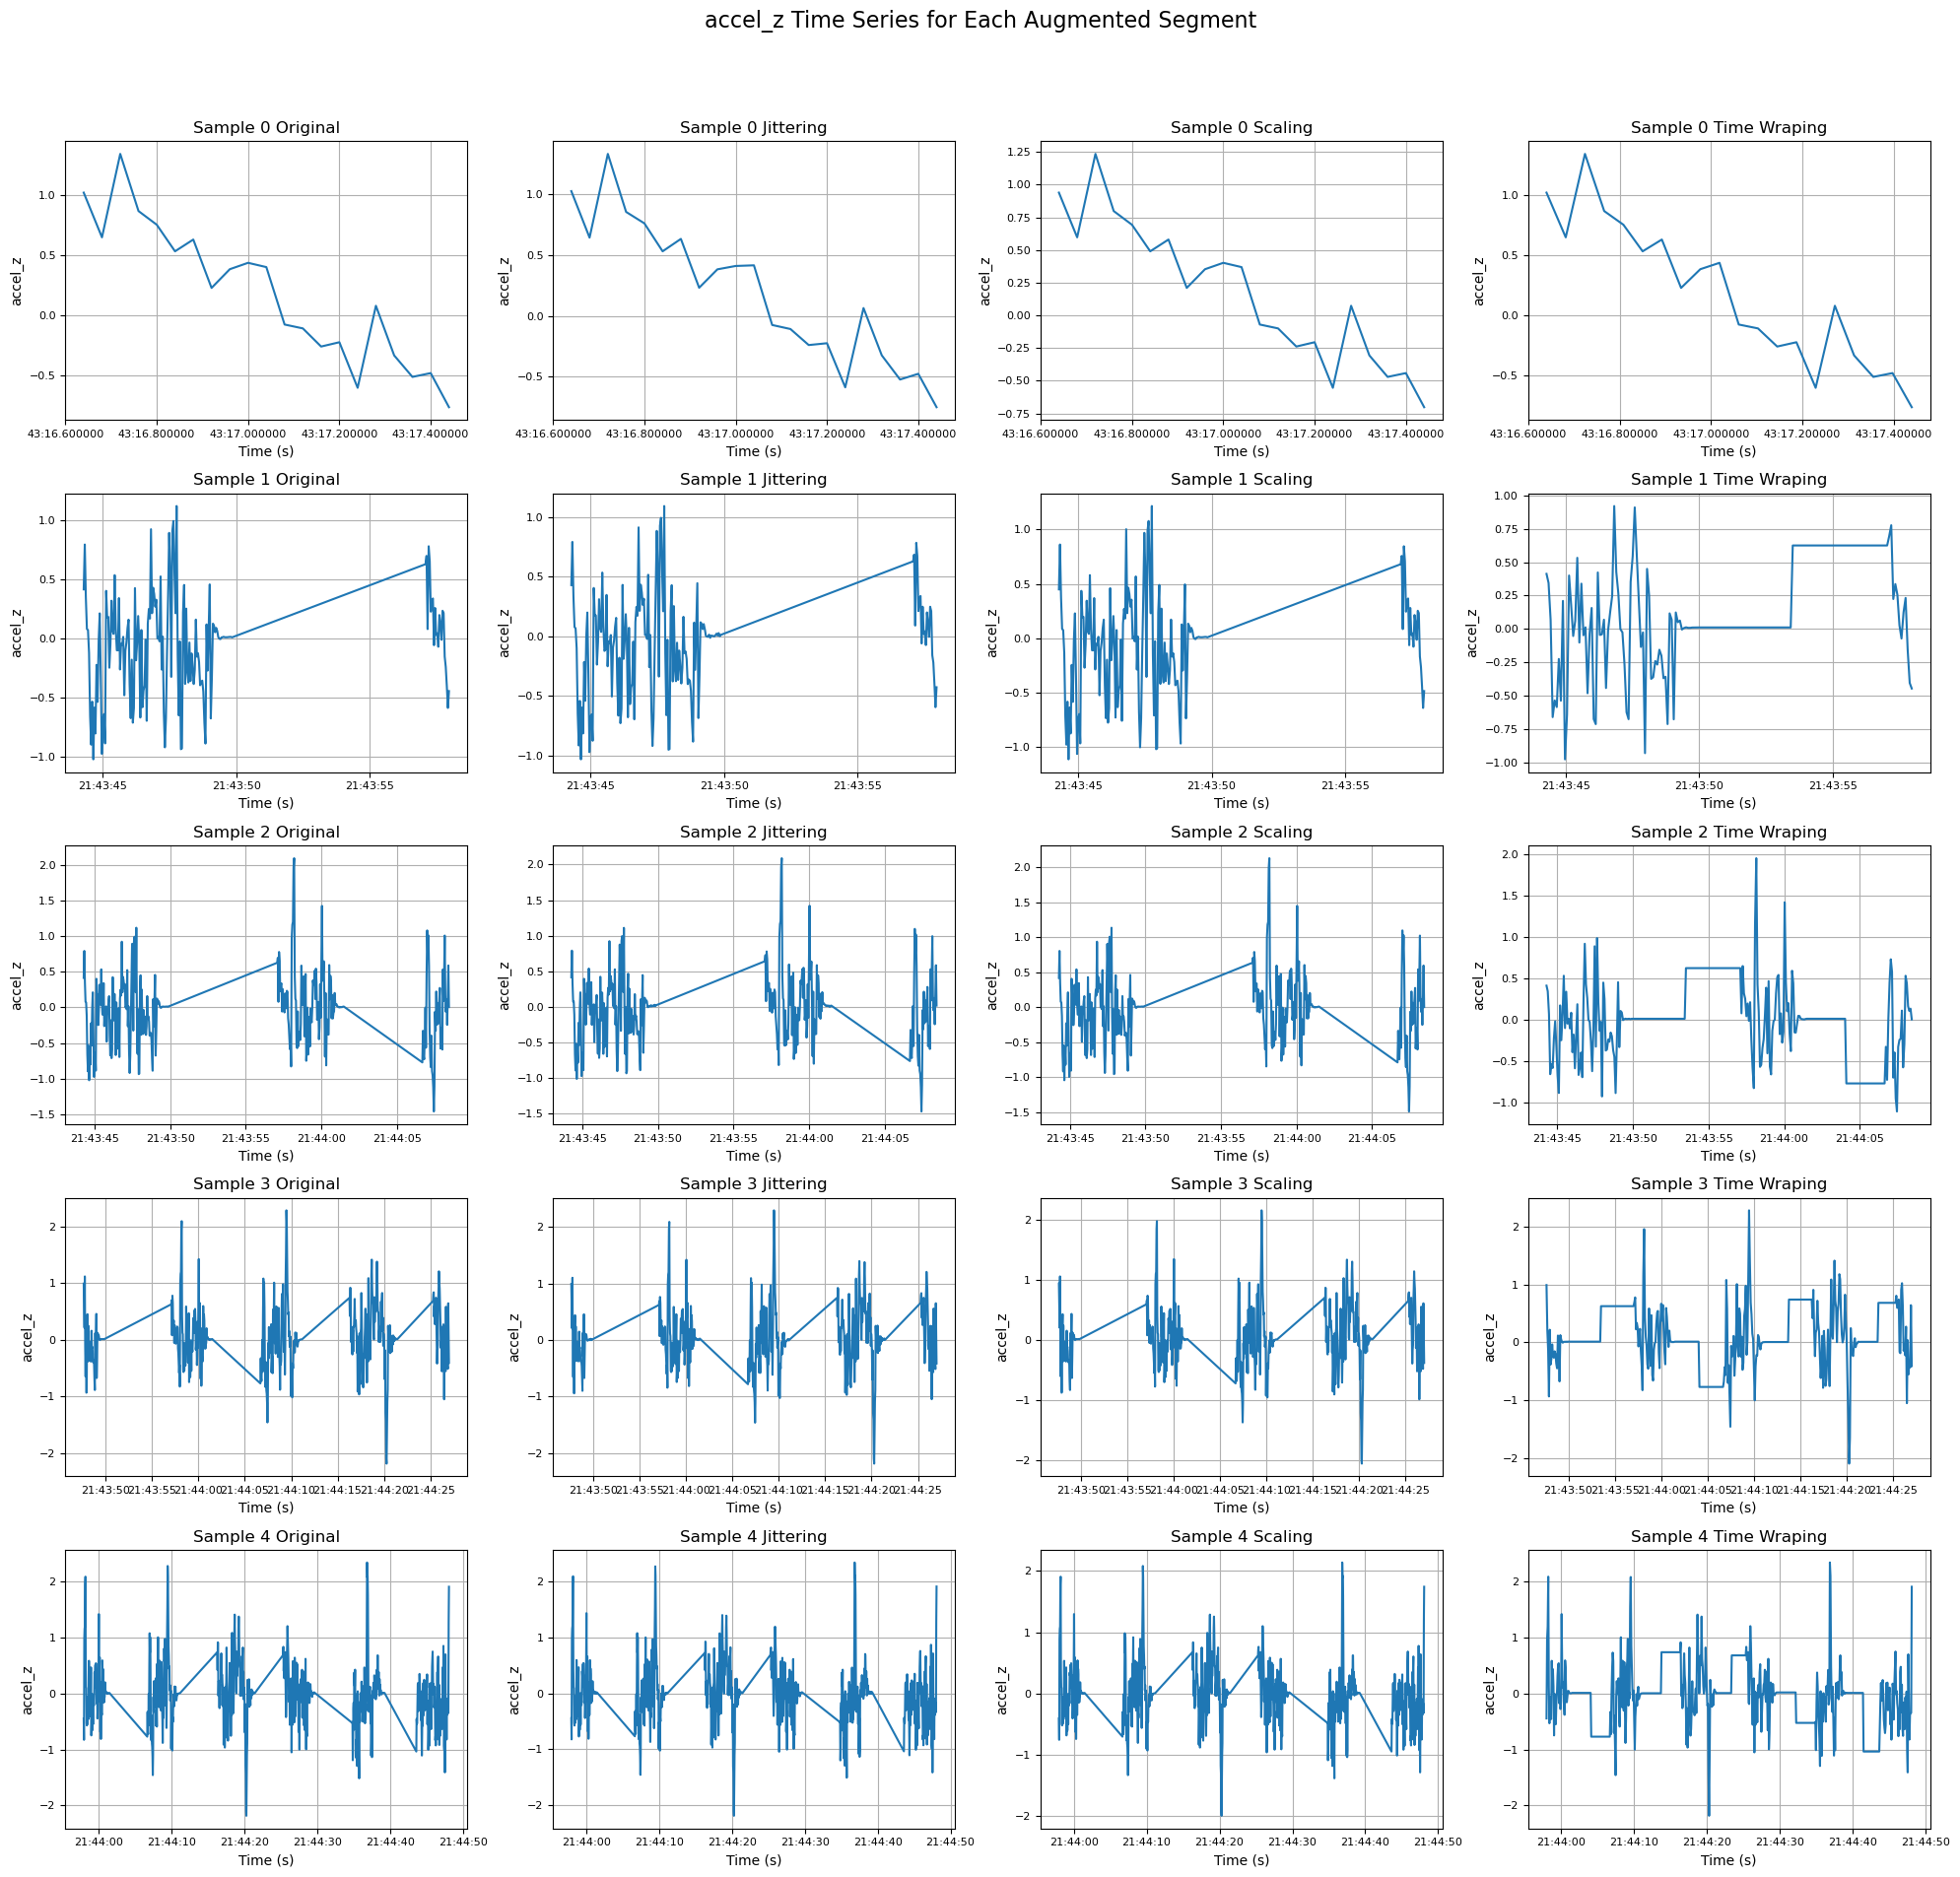

In [16]:
# Define the grid size for subplots
rows = 5
cols = 4

# Plot accel_z for each segment
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Adjust figsize as needed
fig.suptitle('accel_z Time Series for Each Augmented Segment', fontsize=16)

title_list = ['Original', 'Jittering', 'Scaling', 'Time Wraping']

for idx, segment in enumerate(
    augmented_segments[0:4]+
    augmented_segments[1020:1024]+
    augmented_segments[2040:2044]+
    augmented_segments[3060:3064]+
    augmented_segments[4080:4084]
    ):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    ax.plot(segment['time'], segment['accel_z'])
    ax.set_title(f'Sample {idx // 4} {title_list[idx % 4]}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('accel_z')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()


## Feature Computation

In [17]:
# Prepare the data sequences for models
def prepare_sequence_data(segments, targets, sequence_length=10, dt=1/25.0):
    X = []
    y = []

    # 要计算特征的列
    accel_axes = ['accel_x', 'accel_y', 'accel_z', 'accel_magnitude']
    gyro_axes = ['gyro_x', 'gyro_y', 'gyro_z', 'gyro_magnitude']
    all_axes = accel_axes + gyro_axes

    total_length = 3000
    window_size = total_length // sequence_length  # 每个子窗口大小

    for segment, target in zip(segments, targets):
        df = segment.copy()

        # 截断或填充至3000行
        if len(df) < total_length:
            # 填充0行
            num_missing = total_length - len(df)
            padding_df = pd.DataFrame(np.zeros((num_missing, len(df.columns))), columns=df.columns)
            df = pd.concat([df, padding_df], ignore_index=True)
        else:
            df = df.iloc[:total_length].reset_index(drop=True)

        # 计算统计特征
        for col in all_axes:
            df[f'{col}_mean'] = df[col].rolling(window=window_size, min_periods=window_size).mean()
            df[f'{col}_std'] = df[col].rolling(window=window_size, min_periods=window_size).std()
            df[f'{col}_max'] = df[col].rolling(window=window_size, min_periods=window_size).max()
            df[f'{col}_min'] = df[col].rolling(window=window_size, min_periods=window_size).min()
            df[f'{col}_median'] = df[col].rolling(window=window_size, min_periods=window_size).quantile(0.5)
            df[f'{col}_integral'] = df[col].rolling(window=window_size, min_periods=window_size).sum() * dt

        # 去掉无法形成完整窗口的起始行
        df = df.dropna().reset_index(drop=True)

        # 特征列
        stats = ['mean', 'std', 'max', 'min', 'median', 'integral']
        feature_cols = [f'{axis}_{st}' for axis in all_axes for st in stats]

        # 根据新的索引，从0开始每隔window_size取一行特征
        feature_matrix = []
        for i in range(sequence_length):
            idx = i * window_size  # 第 i 个窗口结果的索引
            if idx < len(df):
                row_features = df.iloc[idx][feature_cols].values
            else:
                # 不够则用0填充
                row_features = np.zeros(len(feature_cols))
            feature_matrix.append(row_features)

        feature_matrix = np.array(feature_matrix)

        X.append(feature_matrix)
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    return X, y, feature_cols

In [18]:
# Prepare the data
sequence_length = 10
X_seq, y_seq, feature_names = prepare_sequence_data(augmented_segments, augmented_targets, sequence_length=sequence_length)
num_features = X_seq.shape[2]  # Update num_features based on new data
print(f"Number of features: {num_features}")
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)

X_test_seq, _, _ = prepare_sequence_data(all_motion_segments_test, [None] * len(all_motion_segments_test), sequence_length=sequence_length)
X_test_seq_flat = X_test_seq.reshape(X_test_seq.shape[0], -1)

Number of features: 48


## ML Models

In [19]:
from sklearn.model_selection import train_test_split

X = X_seq_flat
y = np.array(augmented_targets)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = X_test_seq_flat

In [20]:
print(len(y_train), len(y_val))

4080 1020


### Random Forest Regression

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid for hyperparameter tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search Cross-Validation
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
rf_grid_search.fit(X_train, y_train)

# Best estimator
best_rf = rf_grid_search.best_estimator_

# Evaluate the model
y_pred_rf = best_rf.predict(X_val)

print("Random Forest Regression Metrics:")
print(f"MAE: {mean_absolute_error(y_val, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_rf)):.2f}")
print(f"R² Score: {r2_score(y_val, y_pred_rf):.2f}")

# Print the best parameters
print("\nBest Parameters from Grid Search:")
print(rf_grid_search.best_params_)

# # Feature importance
# feature_importances = best_rf.feature_importances_
# feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Print feature importances
# print("\nFeature Importances (sorted):")
# print(importance_df)

Random Forest Regression Metrics:
MAE: 0.43
RMSE: 0.71
R² Score: 1.00

Best Parameters from Grid Search:
{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}


In [22]:
best_rf.predict(X_test)

array([43.145])

### Support Vector Regression

In [23]:
from sklearn.svm import SVR

# Define the parameter grid for hyperparameter tuning
svr_param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2]
}

# Initialize the SVR model
svr = SVR()

# Perform Grid Search Cross-Validation
svr_grid_search = GridSearchCV(estimator=svr, param_grid=svr_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
svr_grid_search.fit(X_train, y_train)

# Best estimator
best_svr = svr_grid_search.best_estimator_

# Evaluate the model
y_pred_svr = best_svr.predict(X_val)

print("\nSupport Vector Regression Metrics:")
print(f"MAE: {mean_absolute_error(y_val, y_pred_svr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_svr)):.2f}")
print(f"R² Score: {r2_score(y_val, y_pred_svr):.2f}")

# Print the best parameters
print("\nBest Parameters from Grid Search:")
print(svr_grid_search.best_params_)



Support Vector Regression Metrics:
MAE: 0.64
RMSE: 0.94
R² Score: 0.99

Best Parameters from Grid Search:
{'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}


In [24]:
best_svr.predict(X_test)

array([35.24477002])

## DL models

In [25]:
# # Prepare the data sequences for the CNN-GRU model
# def prepare_sequence_data(segments, targets, sequence_length):
#     X = []
#     y = []
#     for segment, target in zip(segments, targets):
#         # Extract sensor data columns
#         data = segment[['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']].copy()

#         # Compute additional features
#         # 1. Magnitude of acceleration and gyroscope data
#         data['accel_mag'] = np.sqrt(data['accel_x']**2 + data['accel_y']**2 + data['accel_z']**2)
#         data['gyro_mag'] = np.sqrt(data['gyro_x']**2 + data['gyro_y']**2 + data['gyro_z']**2)

#         # 2. Rolling mean and std (window size = 5)
#         window_size = 5
#         for col in ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
#             data[f'{col}_roll_mean'] = data[col].rolling(window=window_size, min_periods=1).mean()
#             data[f'{col}_roll_std'] = data[col].rolling(window=window_size, min_periods=1).std().fillna(0)

#         # 3. Cumulative sum (integral)
#         for col in ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
#             data[f'{col}_cumsum'] = data[col].cumsum()

#         # Select the features to use
#         features = data.columns  # Use all columns including the new features
#         data = data[features].values  # Convert to numpy array

#         # Pad or truncate sequences
#         if len(data) < sequence_length:
#             # Pad with zeros at the end
#             padding = np.zeros((sequence_length - len(data), data.shape[1]))
#             data = np.vstack((data, padding))
#         else:
#             # Truncate the sequence
#             data = data[:sequence_length]
#         X.append(data)
#         y.append(target)
#     X = np.array(X)
#     y = np.array(y)
#     return X, y, features  # Return features for reference

In [27]:
# Prepare the data
sequence_length = 300
X_seq, y_seq, feature_names = prepare_sequence_data(augmented_segments, augmented_targets, sequence_length=sequence_length)
num_features = X_seq.shape[2]  # Update num_features based on new data
print(f"Number of features: {num_features}")

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

X_test_seq, _, _ = prepare_sequence_data(all_motion_segments_test, [None] * len(all_motion_segments_test), sequence_length=sequence_length)

Number of features: 48


In [28]:
X_train_seq.shape, X_val_seq.shape, X_test_seq.shape

((4080, 300, 48), (1020, 300, 48), (1, 300, 48))

### CNN-GRU

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [30]:
# Create PyTorch Datasets
class IMUDatasetSequence(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, sequence_length, num_features)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape: (num_samples,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the CNN-GRU model
class CNN_GRU_Model(nn.Module):
    def __init__(self, num_features, sequence_length, n_filters, hidden_size, dropout_rate):
        super(CNN_GRU_Model, self).__init__()
        self.num_features = num_features
        self.sequence_length = sequence_length

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=n_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # GRU layers
        self.gru = nn.GRU(input_size=n_filters, hidden_size=hidden_size, num_layers=1, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value for regression

    def forward(self, x):
        # x: (batch_size, sequence_length, num_features)
        x = x.permute(0, 2, 1)  # x: (batch_size, num_features, sequence_length)
        x = self.conv1(x)        # x: (batch_size, n_filters, sequence_length)
        x = self.relu(x)
        x = self.pool(x)         # x: (batch_size, n_filters, sequence_length//2)
        x = x.permute(0, 2, 1)   # x: (batch_size, sequence_length//2, n_filters)
        x, _ = self.gru(x)       # x: (batch_size, seq_length//2, hidden_size)
        x = x[:, -1, :]          # Take the output from the last time step
        x = self.dropout(x)
        x = self.fc(x)           # x: (batch_size, 1)
        return x.squeeze(-1)     # Output shape: (batch_size)

In [31]:
X_train_seq = np.array(X_train_seq, dtype=np.float32)
y_train_seq = np.array(y_train_seq, dtype=np.float32)

X_val_seq = np.array(X_val_seq, dtype=np.float32)
y_val_seq = np.array(y_val_seq, dtype=np.float32)

X_test_seq = np.array(X_test_seq, dtype=np.float32)

In [32]:
train_dataset_seq = IMUDatasetSequence(X_train_seq, y_train_seq)
val_dataset_seq = IMUDatasetSequence(X_val_seq, y_val_seq)

# Hyperparameters to tune
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
dropout_rates = [0.0, 0.2]
num_filters = [16, 32]
hidden_sizes = [64, 128]

# Initialize variables to store the best model and its performance
best_model_seq = None
best_val_loss_seq = float('inf')
best_hyperparams_seq = None

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the results list to store all hyperparameter combinations and their results
results_seq = []

# Loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for dropout_rate in dropout_rates:
            for n_filters in num_filters:
                for hidden_size in hidden_sizes:
                    print(f"Training CNN-GRU model with lr={lr}, batch_size={batch_size}, dropout_rate={dropout_rate}, num_filters={n_filters}, hidden_size={hidden_size}")

                    # Create DataLoaders
                    train_loader_seq = DataLoader(train_dataset_seq, batch_size=batch_size, shuffle=True)
                    val_loader_seq = DataLoader(val_dataset_seq, batch_size=batch_size, shuffle=False)

                    # Initialize the model and move it to the device
                    model_seq = CNN_GRU_Model(
                        num_features=num_features,
                        sequence_length=sequence_length,
                        n_filters=n_filters,
                        hidden_size=hidden_size,
                        dropout_rate=dropout_rate
                    )
                    model_seq.to(device)

                    # Loss function and optimizer
                    criterion_seq = nn.MSELoss()
                    optimizer_seq = optim.Adam(model_seq.parameters(), lr=lr)

                    num_epochs = 50
                    train_losses_seq = []
                    val_losses_seq = []

                    for epoch in range(num_epochs):
                        model_seq.train()
                        epoch_train_losses = []
                        for batch_X, batch_y in train_loader_seq:
                            # Move data to device
                            batch_X = batch_X.to(device)
                            batch_y = batch_y.to(device)

                            optimizer_seq.zero_grad()
                            outputs = model_seq(batch_X)
                            loss = criterion_seq(outputs, batch_y)
                            loss.backward()
                            optimizer_seq.step()
                            epoch_train_losses.append(loss.item())
                        train_losses_seq.append(np.mean(epoch_train_losses))

                        # Validation
                        model_seq.eval()
                        epoch_val_losses = []
                        val_predictions = []
                        val_targets = []
                        with torch.no_grad():
                            for batch_X, batch_y in val_loader_seq:
                                # Move data to device
                                batch_X = batch_X.to(device)
                                batch_y = batch_y.to(device)

                                outputs = model_seq(batch_X)
                                loss = criterion_seq(outputs, batch_y)
                                epoch_val_losses.append(loss.item())
                                val_predictions.extend(outputs.cpu().numpy())
                                val_targets.extend(batch_y.cpu().numpy())
                        val_loss = np.mean(epoch_val_losses)
                        val_losses_seq.append(val_loss)

                        if (epoch+1) % 10 == 0:
                            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_seq[-1]:.4f}, Val Loss: {val_losses_seq[-1]:.4f}")

                    # Evaluate the model
                    mae = mean_absolute_error(val_targets, val_predictions)
                    rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
                    r2 = r2_score(val_targets, val_predictions)

                    print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}, R² Score: {r2:.2f}")

                    # Save the model if it has the best validation loss
                    if val_loss < best_val_loss_seq:
                        best_val_loss_seq = val_loss
                        best_model_seq = model_seq
                        best_hyperparams_seq = {
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'dropout_rate': dropout_rate,
                            'num_filters': n_filters,
                            'hidden_size': hidden_size
                        }
                        # Save the losses for plotting
                        best_train_losses_seq = train_losses_seq.copy()
                        best_val_losses_seq = val_losses_seq.copy()
                        # Save the predictions and targets for evaluation
                        best_val_predictions_seq = val_predictions.copy()
                        best_val_targets_seq = val_targets.copy()

                    # Append the results for visualization
                    results_seq.append({
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'dropout_rate': dropout_rate,
                        'num_filters': n_filters,
                        'hidden_size': hidden_size,
                        'val_loss': val_loss,
                        'val_mae': mae,
                        'val_rmse': rmse,
                        'val_r2': r2
                    })

                    print("-" * 50)

# Print the best hyperparameters
print("\nBest Hyperparameters for CNN-GRU Model:")
print(best_hyperparams_seq)

Training CNN-GRU model with lr=0.001, batch_size=32, dropout_rate=0.0, num_filters=16, hidden_size=64
Epoch [10/50], Train Loss: 3.9367, Val Loss: 4.0453
Epoch [20/50], Train Loss: 1.0966, Val Loss: 0.9098
Epoch [30/50], Train Loss: 0.3679, Val Loss: 0.5081
Epoch [40/50], Train Loss: 0.2607, Val Loss: 0.2223
Epoch [50/50], Train Loss: 0.1730, Val Loss: 0.1625
Validation MAE: 0.30, RMSE: 0.40, R² Score: 1.00
--------------------------------------------------
Training CNN-GRU model with lr=0.001, batch_size=32, dropout_rate=0.0, num_filters=16, hidden_size=128
Epoch [10/50], Train Loss: 1.4891, Val Loss: 1.2610
Epoch [20/50], Train Loss: 0.4919, Val Loss: 0.3579
Epoch [30/50], Train Loss: 0.2675, Val Loss: 0.5004
Epoch [40/50], Train Loss: 0.1407, Val Loss: 0.2738
Epoch [50/50], Train Loss: 0.1610, Val Loss: 0.1559
Validation MAE: 0.30, RMSE: 0.39, R² Score: 1.00
--------------------------------------------------
Training CNN-GRU model with lr=0.001, batch_size=32, dropout_rate=0.0, num_

In [33]:
# Create Datasets
test_dataset_seq = IMUDatasetSequence(X_test_seq, np.array([0] * X_test_seq.shape[0]))

# Create DataLoaders
test_loader_seq = DataLoader(test_dataset_seq, batch_size=batch_size, shuffle=False)

# Testing
best_model_seq.eval()
test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader_seq:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = best_model_seq(batch_X)
        test_predictions.extend(outputs.cpu().numpy())

test_predictions

[46.719585]

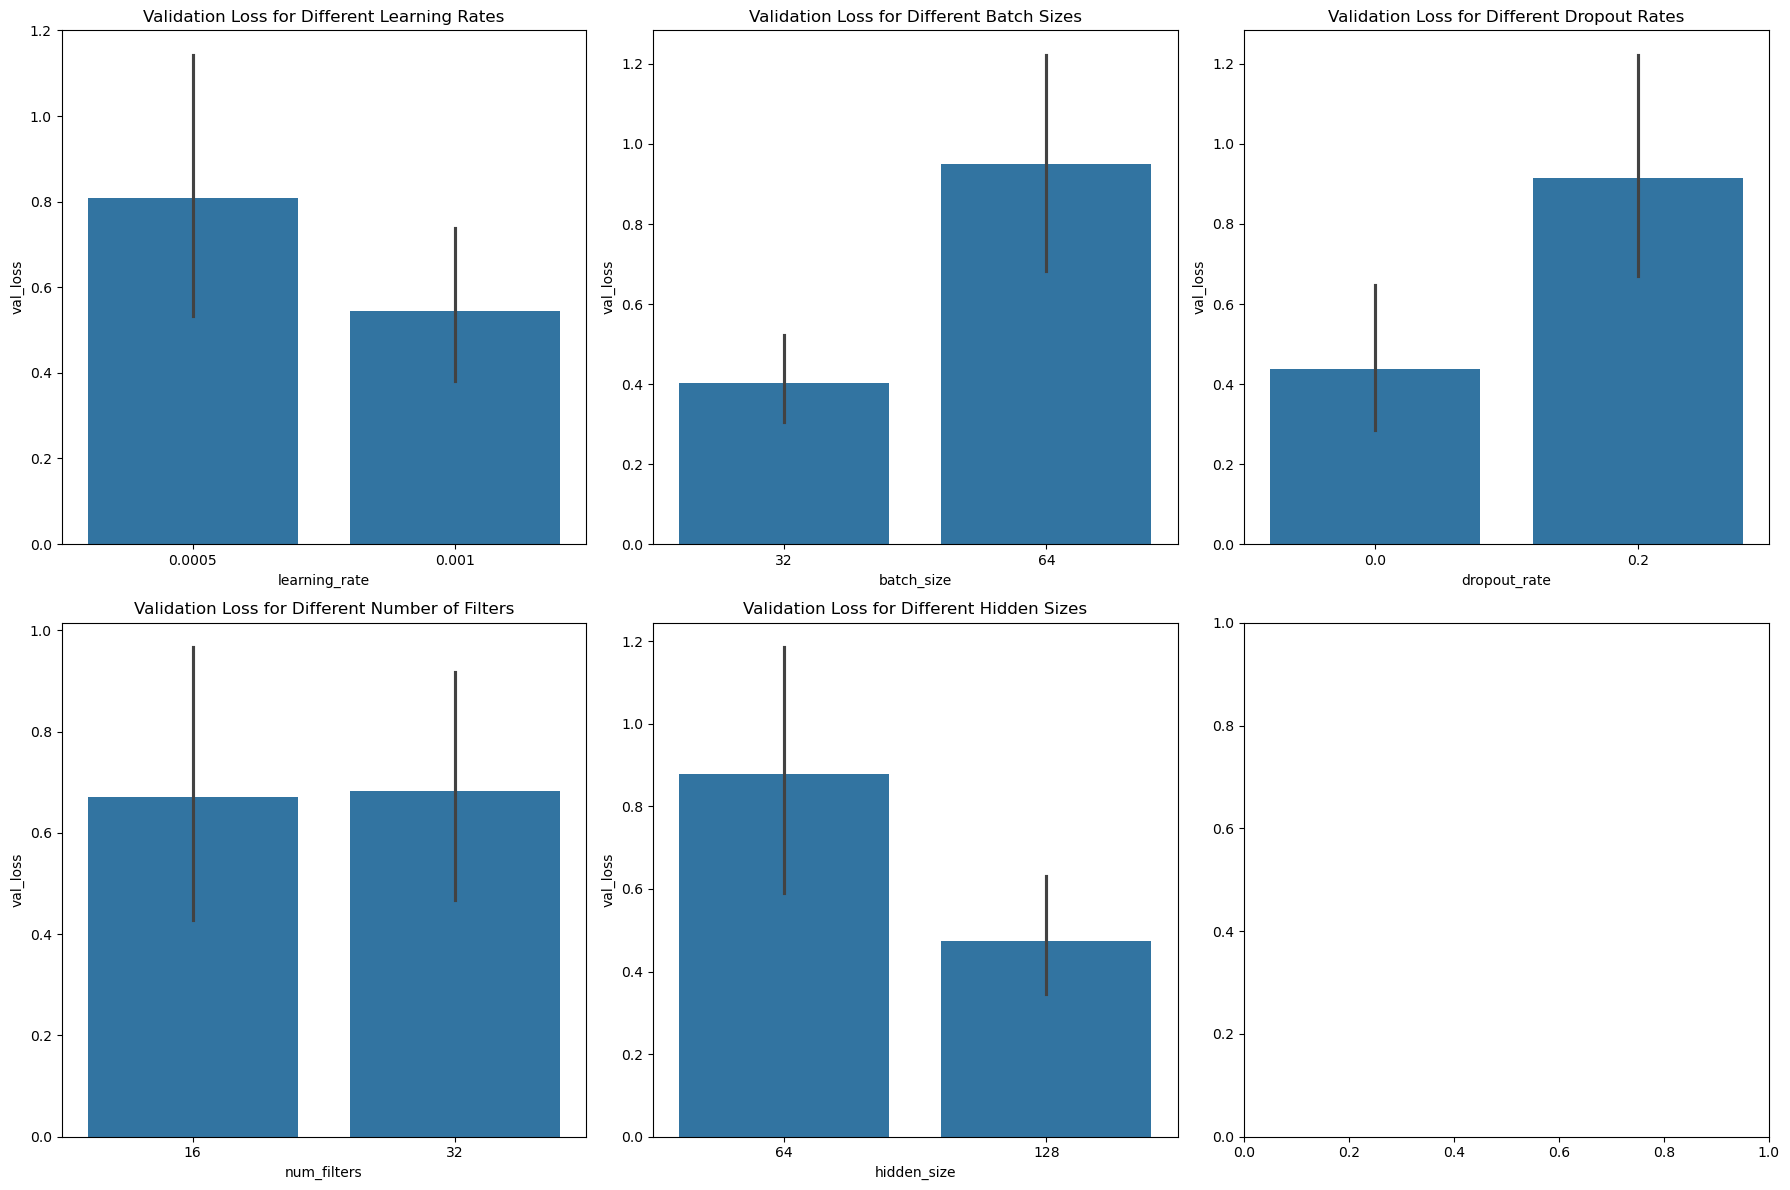

In [34]:
# Visualize hyperparameter tuning results in a single figure with multiple subplots
import pandas as pd
import seaborn as sns

results_seq_df = pd.DataFrame(results_seq)

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot validation loss for different learning rates
sns.barplot(ax=axes[0], x='learning_rate', y='val_loss', data=results_seq_df)
axes[0].set_title('Validation Loss for Different Learning Rates')

# Plot validation loss for different batch sizes
sns.barplot(ax=axes[1], x='batch_size', y='val_loss', data=results_seq_df)
axes[1].set_title('Validation Loss for Different Batch Sizes')

# Plot validation loss for different dropout rates
sns.barplot(ax=axes[2], x='dropout_rate', y='val_loss', data=results_seq_df)
axes[2].set_title('Validation Loss for Different Dropout Rates')

# Plot validation loss for different number of filters
sns.barplot(ax=axes[3], x='num_filters', y='val_loss', data=results_seq_df)
axes[3].set_title('Validation Loss for Different Number of Filters')

# Plot validation loss for different hidden sizes
sns.barplot(ax=axes[4], x='hidden_size', y='val_loss', data=results_seq_df)
axes[4].set_title('Validation Loss for Different Hidden Sizes')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### CNN

In [35]:
# Define the CNN-only model
class CNN_Model(nn.Module):
    def __init__(self, num_features, sequence_length, n_filters, hidden_size, dropout_rate):
        super(CNN_Model, self).__init__()
        self.num_features = num_features
        self.sequence_length = sequence_length

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=n_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(n_filters * (sequence_length // 2), hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch_size, sequence_length, num_features)
        x = x.permute(0, 2, 1)  # x: (batch_size, num_features, sequence_length)
        x = self.conv1(x)        # x: (batch_size, n_filters, sequence_length)
        x = self.relu(x)
        x = self.pool(x)         # x: (batch_size, n_filters, sequence_length//2)
        x = self.flatten(x)      # x: (batch_size, n_filters * sequence_length//2)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)          # x: (batch_size, 1)
        return x.squeeze(-1)     # Output shape: (batch_size)

# Training and evaluation for CNN-only model
train_dataset_seq = IMUDatasetSequence(X_train_seq, y_train_seq)
val_dataset_seq = IMUDatasetSequence(X_val_seq, y_val_seq)

# Use the best hyperparameters from the CNN-GRU model
best_hyperparams_cnn = best_hyperparams_seq  # Use the same hyperparameters

# Create DataLoaders
batch_size = best_hyperparams_cnn['batch_size']
train_loader_seq = DataLoader(train_dataset_seq, batch_size=batch_size, shuffle=True)
val_loader_seq = DataLoader(val_dataset_seq, batch_size=batch_size, shuffle=False)

# Initialize the model and move it to the device
model_cnn = CNN_Model(
    num_features=num_features,
    sequence_length=sequence_length,
    n_filters=best_hyperparams_cnn['num_filters'],
    hidden_size=best_hyperparams_cnn['hidden_size'],
    dropout_rate=best_hyperparams_cnn['dropout_rate']
)
model_cnn.to(device)

# Loss function and optimizer
criterion_cnn = nn.MSELoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=best_hyperparams_cnn['learning_rate'])

# Training loop
num_epochs = 50
train_losses_cnn = []
val_losses_cnn = []

for epoch in range(num_epochs):
    model_cnn.train()
    epoch_train_losses = []
    for batch_X, batch_y in train_loader_seq:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer_cnn.zero_grad()
        outputs = model_cnn(batch_X)
        loss = criterion_cnn(outputs, batch_y)
        loss.backward()
        optimizer_cnn.step()
        epoch_train_losses.append(loss.item())
    train_losses_cnn.append(np.mean(epoch_train_losses))

    # Validation
    model_cnn.eval()
    epoch_val_losses = []
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader_seq:
            # Move data to device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model_cnn(batch_X)
            loss = criterion_cnn(outputs, batch_y)
            epoch_val_losses.append(loss.item())
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(batch_y.cpu().numpy())
    val_loss = np.mean(epoch_val_losses)
    val_losses_cnn.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_cnn[-1]:.4f}, Val Loss: {val_losses_cnn[-1]:.4f}")

# Evaluate the model on the validation set
mae_cnn = mean_absolute_error(val_targets, val_predictions)
rmse_cnn = np.sqrt(mean_squared_error(val_targets, val_predictions))
r2_cnn = r2_score(val_targets, val_predictions)

print("\nCNN-only Model Evaluation on Validation Set:")
print(f"MAE: {mae_cnn:.2f}")
print(f"RMSE: {rmse_cnn:.2f}")
print(f"R² Score: {r2_cnn:.2f}")


Epoch [10/50], Train Loss: 0.5831, Val Loss: 0.6758
Epoch [20/50], Train Loss: 0.6167, Val Loss: 0.7902
Epoch [30/50], Train Loss: 0.5838, Val Loss: 0.5655
Epoch [40/50], Train Loss: 0.5461, Val Loss: 1.1578
Epoch [50/50], Train Loss: 0.3914, Val Loss: 0.4985

CNN-only Model Evaluation on Validation Set:
MAE: 0.49
RMSE: 0.71
R² Score: 1.00


In [36]:
# Create Datasets
test_dataset_seq = IMUDatasetSequence(X_test_seq, np.array([0] * X_test_seq.shape[0]))

# Create DataLoaders
test_loader_seq = DataLoader(test_dataset_seq, batch_size=batch_size, shuffle=False)

# Testing
model_cnn.eval()
test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader_seq:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model_cnn(batch_X)
        test_predictions.extend(outputs.cpu().numpy())

test_predictions

[39.293808]

### GRU

In [37]:
# Define the GRU-only model
class GRU_Model(nn.Module):
    def __init__(self, num_features, sequence_length, hidden_size, dropout_rate):
        super(GRU_Model, self).__init__()
        self.num_features = num_features
        self.sequence_length = sequence_length

        # GRU layers
        self.gru = nn.GRU(input_size=num_features, hidden_size=hidden_size, num_layers=1, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value for regression

    def forward(self, x):
        # x: (batch_size, sequence_length, num_features)
        x, _ = self.gru(x)       # x: (batch_size, seq_length, hidden_size)
        x = x[:, -1, :]          # Take the output from the last time step
        x = self.dropout(x)
        x = self.fc(x)           # x: (batch_size, 1)
        return x.squeeze(-1)     # Output shape: (batch_size)

# Training and evaluation for GRU-only model
train_dataset_seq = IMUDatasetSequence(X_train_seq, y_train_seq)
val_dataset_seq = IMUDatasetSequence(X_val_seq, y_val_seq)

# Use the best hyperparameters from the CNN-GRU model (adjust as needed)
best_hyperparams_gru = {
    'learning_rate': best_hyperparams_seq['learning_rate'],
    'batch_size': best_hyperparams_seq['batch_size'],
    'dropout_rate': best_hyperparams_seq['dropout_rate'],
    'hidden_size': best_hyperparams_seq['hidden_size']
}

# Create DataLoaders
batch_size = best_hyperparams_gru['batch_size']
train_loader_seq = DataLoader(train_dataset_seq, batch_size=batch_size, shuffle=True)
val_loader_seq = DataLoader(val_dataset_seq, batch_size=batch_size, shuffle=False)

# Initialize the model and move it to the device
model_gru = GRU_Model(
    num_features=num_features,
    sequence_length=sequence_length,
    hidden_size=best_hyperparams_gru['hidden_size'],
    dropout_rate=best_hyperparams_gru['dropout_rate']
)
model_gru.to(device)

# Loss function and optimizer
criterion_gru = nn.MSELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=best_hyperparams_gru['learning_rate'])

# Training loop
num_epochs = 50
train_losses_gru = []
val_losses_gru = []

for epoch in range(num_epochs):
    model_gru.train()
    epoch_train_losses = []
    for batch_X, batch_y in train_loader_seq:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer_gru.zero_grad()
        outputs = model_gru(batch_X)
        loss = criterion_gru(outputs, batch_y)
        loss.backward()
        optimizer_gru.step()
        epoch_train_losses.append(loss.item())
    train_losses_gru.append(np.mean(epoch_train_losses))

    # Validation
    model_gru.eval()
    epoch_val_losses = []
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader_seq:
            # Move data to device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model_gru(batch_X)
            loss = criterion_gru(outputs, batch_y)
            epoch_val_losses.append(loss.item())
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(batch_y.cpu().numpy())
    val_loss = np.mean(epoch_val_losses)
    val_losses_gru.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_gru[-1]:.4f}, Val Loss: {val_losses_gru[-1]:.4f}")

# Evaluate the model on the validation set
mae_gru = mean_absolute_error(val_targets, val_predictions)
rmse_gru = np.sqrt(mean_squared_error(val_targets, val_predictions))
r2_gru = r2_score(val_targets, val_predictions)

print("\nGRU-only Model Evaluation on Validation Set:")
print(f"MAE: {mae_gru:.2f}")
print(f"RMSE: {rmse_gru:.2f}")
print(f"R² Score: {r2_gru:.2f}")

Epoch [10/50], Train Loss: 140.1516, Val Loss: 148.4528
Epoch [20/50], Train Loss: 7.7853, Val Loss: 7.3759
Epoch [30/50], Train Loss: 0.5583, Val Loss: 0.6761
Epoch [40/50], Train Loss: 0.2867, Val Loss: 0.2631
Epoch [50/50], Train Loss: 0.1853, Val Loss: 0.2914

GRU-only Model Evaluation on Validation Set:
MAE: 0.41
RMSE: 0.54
R² Score: 1.00


In [38]:
# Create Datasets
test_dataset_seq = IMUDatasetSequence(X_test_seq, np.array([0] * X_test_seq.shape[0]))

# Create DataLoaders
test_loader_seq = DataLoader(test_dataset_seq, batch_size=batch_size, shuffle=False)

# Testing
model_gru.eval()
test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader_seq:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model_gru(batch_X)
        test_predictions.extend(outputs.cpu().numpy())

test_predictions

[25.76682]

### Los plot & CV for CNN-GRU

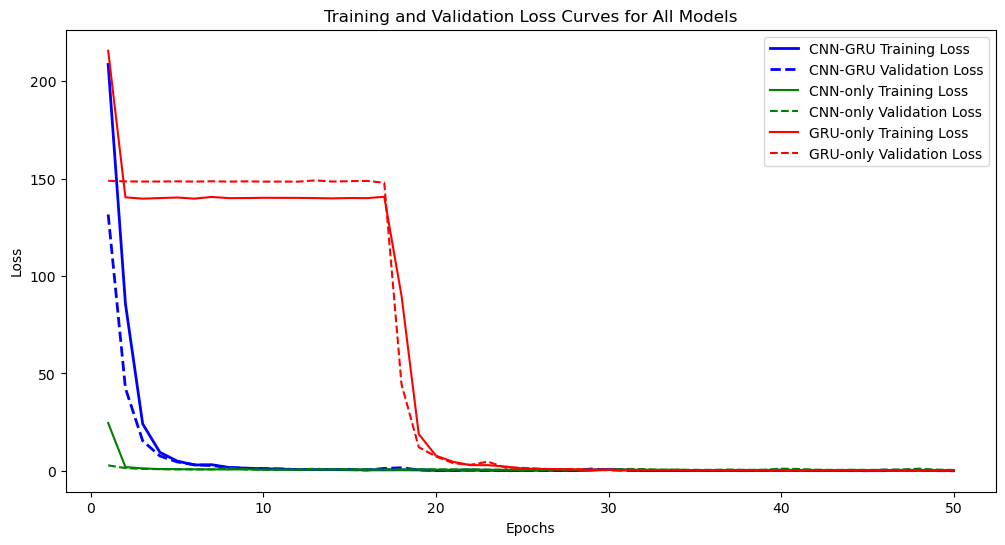

In [39]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves together
plt.figure(figsize=(12,6))

# CNN-GRU Model Losses
plt.plot(range(1, num_epochs+1), best_train_losses_seq, label='CNN-GRU Training Loss', color='blue', linewidth=2)
plt.plot(range(1, num_epochs+1), best_val_losses_seq, label='CNN-GRU Validation Loss', color='blue', linestyle='--', linewidth=2)

# CNN-only Model Losses
plt.plot(range(1, num_epochs+1), train_losses_cnn, label='CNN-only Training Loss', color='green')
plt.plot(range(1, num_epochs+1), val_losses_cnn, label='CNN-only Validation Loss', color='green', linestyle='--')

# GRU-only Model Losses
plt.plot(range(1, num_epochs+1), train_losses_gru, label='GRU-only Training Loss', color='red')
plt.plot(range(1, num_epochs+1), val_losses_gru, label='GRU-only Validation Loss', color='red', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for All Models')
plt.legend()
plt.show()

Cross-Validation

In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 1
mae_scores_cnn_gru = []
rmse_scores_cnn_gru = []
r2_scores_cnn_gru = []

for train_index, val_index in kf.split(X_seq):
    print(f"\nCNN-GRU Model - Fold {fold}/{n_splits}")
    # Split data
    X_train_fold = X_seq[train_index]
    y_train_fold = y_seq[train_index]
    X_val_fold = X_seq[val_index]
    y_val_fold = y_seq[val_index]

    X_train_fold = np.array(X_train_fold, dtype=np.float32)
    y_train_fold = np.array(y_train_fold, dtype=np.float32)
    X_val_fold = np.array(X_val_fold, dtype=np.float32)
    y_val_fold = np.array(y_val_fold, dtype=np.float32)

    # Create Datasets
    train_dataset_fold = IMUDatasetSequence(X_train_fold, y_train_fold)
    val_dataset_fold = IMUDatasetSequence(X_val_fold, y_val_fold)

    # Create DataLoaders
    batch_size = best_hyperparams_seq['batch_size']
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

    # Initialize the model and move it to the device
    model_cnn_gru = CNN_GRU_Model(
        num_features=num_features,
        sequence_length=sequence_length,
        n_filters=best_hyperparams_seq['num_filters'],
        hidden_size=best_hyperparams_seq['hidden_size'],
        dropout_rate=best_hyperparams_seq['dropout_rate']
    )
    model_cnn_gru.to(device)

    # Loss function and optimizer
    criterion_cnn_gru = nn.MSELoss()
    optimizer_cnn_gru = optim.Adam(model_cnn_gru.parameters(), lr=best_hyperparams_seq['learning_rate'])

    # Training loop
    num_epochs = 50

    for epoch in range(num_epochs):
        model_cnn_gru.train()
        for batch_X, batch_y in train_loader_fold:
            # Move data to device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer_cnn_gru.zero_grad()
            outputs = model_cnn_gru(batch_X)
            loss = criterion_cnn_gru(outputs, batch_y)
            loss.backward()
            optimizer_cnn_gru.step()

    # Validation
    model_cnn_gru.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader_fold:
            # Move data to device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model_cnn_gru(batch_X)
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(batch_y.cpu().numpy())

    # Evaluate the model on the validation set
    mae = mean_absolute_error(val_targets, val_predictions)
    rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
    r2 = r2_score(val_targets, val_predictions)

    print(f"Fold {fold} Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

    mae_scores_cnn_gru.append(mae)
    rmse_scores_cnn_gru.append(rmse)
    r2_scores_cnn_gru.append(r2)

    fold += 1

# Compute average metrics
mean_mae_cnn_gru = np.mean(mae_scores_cnn_gru)
mean_rmse_cnn_gru = np.mean(rmse_scores_cnn_gru)
mean_r2_cnn_gru = np.mean(r2_scores_cnn_gru)

print("\nCNN-GRU Model Cross-Validation Results:")
print(f"Average MAE: {mean_mae_cnn_gru:.2f} ± {np.std(mae_scores_cnn_gru):.2f}")
print(f"Average RMSE: {mean_rmse_cnn_gru:.2f} ± {np.std(rmse_scores_cnn_gru):.2f}")
print(f"Average R² Score: {mean_r2_cnn_gru:.2f} ± {np.std(r2_scores_cnn_gru):.2f}")


CNN-GRU Model - Fold 1/5
Fold 1 Evaluation:
MAE: 0.27
RMSE: 0.38
R² Score: 1.00

CNN-GRU Model - Fold 2/5
Fold 2 Evaluation:
MAE: 0.24
RMSE: 0.33
R² Score: 1.00

CNN-GRU Model - Fold 3/5
Fold 3 Evaluation:
MAE: 0.27
RMSE: 0.39
R² Score: 1.00

CNN-GRU Model - Fold 4/5
Fold 4 Evaluation:
MAE: 0.25
RMSE: 0.35
R² Score: 1.00

CNN-GRU Model - Fold 5/5
Fold 5 Evaluation:
MAE: 0.22
RMSE: 0.32
R² Score: 1.00

CNN-GRU Model Cross-Validation Results:
Average MAE: 0.25 ± 0.02
Average RMSE: 0.36 ± 0.03
Average R² Score: 1.00 ± 0.00
